# Imports

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
                                        LogisticRegressionModel, RandomForestClassificationModel, GBTClassificationModel

spark = SparkSession.builder.appName('BigDataProject').getOrCreate()

# Load Data

In [73]:
base_df = spark.read.csv("anime_dataset.csv", header=True, inferSchema=True)
base_df.show(5)

+--------+--------------------+--------------------+-----+--------------------+-----+--------+--------------------+-----------+---------------+--------------------+--------------------+--------------+--------+-------------+--------------------+----+----------+---------+---------+-------+--------------------+
|anime_id|                Name|        English name|Score|              Genres| Type|Episodes|               Aired|  Premiered|         Status|           Producers|           Licensors|       Studios|  Source|     Duration|              Rating|Rank|Popularity|Favorites|Scored By|Members|           Image URL|
+--------+--------------------+--------------------+-----+--------------------+-----+--------+--------------------+-----------+---------------+--------------------+--------------------+--------------+--------+-------------+--------------------+----+----------+---------+---------+-------+--------------------+
|       1|        Cowboy Bebop|        Cowboy Bebop| 8.75|Action, Awar

# Preprocessing the Dataset

### Dropping irrelevant columns

In [74]:
df = base_df.drop("anime_id", "Name", "English name", "Other name", "Image URL")
df.printSchema()

root
 |-- Score: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Episodes: string (nullable = true)
 |-- Aired: string (nullable = true)
 |-- Premiered: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Producers: string (nullable = true)
 |-- Licensors: string (nullable = true)
 |-- Studios: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rank: string (nullable = true)
 |-- Popularity: string (nullable = true)
 |-- Favorites: integer (nullable = true)
 |-- Scored By: string (nullable = true)
 |-- Members: string (nullable = true)



In [75]:
df.count()

9962000

### Dropping any null values

In [76]:
df2 = df.na.drop()
df2.count()

9962000

### Replacing "unknown" values with the average value for that column

In [79]:
from pyspark.sql.functions import col, when, avg


# Convert the "Score" column to double, except for "UNKNOWN"
df_filled = df.withColumn("Score", when(col("Score") == "UNKNOWN", None).otherwise(col("Score").cast("double")))

# Calculate the average of the "Score" column, excluding null values
average_score = df_filled.select(avg(col("Score"))).collect()[0][0]

# Replace "UNKNOWN" values with the average score
df_filled = df_filled.withColumn("Score", when(col("Score").isNull(), average_score).otherwise(col("Score")))





df_filled = df_filled.withColumn("Rank", when(col("Rank") == "UNKNOWN", None).otherwise(col("Rank").cast("double")))
average_score = df_filled.select(avg(col("Rank"))).collect()[0][0]
df_filled = df_filled.withColumn("Rank", when(col("Rank").isNull(), average_score).otherwise(col("Rank")))



df_filled = df_filled.withColumn("Popularity", when(col("Popularity") == "UNKNOWN", None).otherwise(col("Popularity").cast("double")))
average_score = df_filled.select(avg(col("Popularity"))).collect()[0][0]
df_filled = df_filled.withColumn("Popularity", when(col("Popularity").isNull(), average_score).otherwise(col("Popularity")))


df_filled = df_filled.withColumn("Scored By", when(col("Scored By") == "UNKNOWN", None).otherwise(col("Scored By").cast("double")))
average_score = df_filled.select(avg(col("Scored By"))).collect()[0][0]
df_filled = df_filled.withColumn("Scored By", when(col("Scored By").isNull(), average_score).otherwise(col("Scored By")))



df_filled = df_filled.withColumn("Members", when(col("Members") == "UNKNOWN", None).otherwise(col("Members").cast("double")))
average_score = df_filled.select(avg(col("Members"))).collect()[0][0]
df_filled = df_filled.withColumn("Members", when(col("Members").isNull(), average_score).otherwise(col("Members")))



df_filled = df_filled.withColumn("Episodes", when(col("Episodes") == "UNKNOWN", None).otherwise(col("Episodes").cast("double")))
average_score = df_filled.select(avg(col("Episodes"))).collect()[0][0]
df_filled = df_filled.withColumn("Episodes", when(col("Episodes").isNull(), average_score).otherwise(col("Episodes")))




df_filled.show()


+-----+--------------------+-----+-----------------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+---------+
|Score|              Genres| Type|         Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|         Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored By|  Members|
+-----+--------------------+-----+-----------------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+---------+
| 8.75|Action, Award Win...|   TV|             26.0|Apr 3, 1998 to Ap...|spring 1998| Finished Airing|       Bandai Visual|Funimation, Banda...|         Sunrise|   Original|24 min per ep|R - 17+ (violence...|  41.0|      43.0|   

### Transforming all the data into numeric values

In [80]:
from pyspark.sql.types import IntegerType, DoubleType
df_filled = df_filled.withColumn("Rank", col("Rank").cast(IntegerType()))
df_filled = df_filled.withColumn("Popularity", col("Popularity").cast(IntegerType()))
df_filled = df_filled.withColumn("Scored By", col("Scored By").cast(IntegerType()))
df_filled = df_filled.withColumn("Members", col("Members").cast(IntegerType()))
df_filled = df_filled.withColumn("Episodes", col("Episodes").cast(IntegerType()))
df_filled = df_filled.withColumn("Score", col("Score").cast(DoubleType()))
df_filled.printSchema()

root
 |-- Score: double (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Episodes: integer (nullable = true)
 |-- Aired: string (nullable = true)
 |-- Premiered: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Producers: string (nullable = true)
 |-- Licensors: string (nullable = true)
 |-- Studios: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rank: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Favorites: integer (nullable = true)
 |-- Scored By: integer (nullable = true)
 |-- Members: integer (nullable = true)



In [81]:
from pyspark.ml.feature import StringIndexer
df = df_filled
si = StringIndexer(inputCols=["Genres", "Type", "Aired", "Premiered", "Status", "Producers", "Licensors", "Studios", "Source", "Duration", "Rating"], outputCols=["Genres2", "Type2", "Aired2", "Premiered2", "Status2", "Producers2", "Licensors2", "Studios2", "Source2", "Duration2", "Rating2"])
si_fit = si.fit(df)

df_indexed = si_fit.transform(df)

In [82]:
df = df_indexed.drop("Genres", "Type", "Aired", "Premiered", "Status", "Producers", "Licensors", "Studios", "Source", "Duration", "Rating")
df.printSchema()


root
 |-- Score: double (nullable = true)
 |-- Episodes: integer (nullable = true)
 |-- Rank: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Favorites: integer (nullable = true)
 |-- Scored By: integer (nullable = true)
 |-- Members: integer (nullable = true)
 |-- Genres2: double (nullable = false)
 |-- Type2: double (nullable = false)
 |-- Aired2: double (nullable = false)
 |-- Premiered2: double (nullable = false)
 |-- Status2: double (nullable = false)
 |-- Producers2: double (nullable = false)
 |-- Licensors2: double (nullable = false)
 |-- Studios2: double (nullable = false)
 |-- Source2: double (nullable = false)
 |-- Duration2: double (nullable = false)
 |-- Rating2: double (nullable = false)



# Correlation Matrix

In [83]:
df = df.na.drop()
df.count()

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

corr = Correlation.corr(df_vector, vector_col)

matrix = corr.collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df.columns, index=df.columns) 
corr_matrix_df.style.background_gradient(cmap='coolwarm')

,Score,Episodes,Rank,Popularity,Favorites,Scored By,Members,Genres2,Type2,Aired2,Premiered2,Status2,Producers2,Licensors2,Studios2,Source2,Duration2,Rating2
Score,1.000000,0.063062,-0.487308,-0.378494,0.234712,0.351091,0.384601,0.128293,-0.202985,0.033248,0.184380,0.025816,0.227117,0.155237,-0.017369,0.051711,-0.020046,-0.064177
Episodes,0.063062,1.000000,0.062305,0.090484,0.042837,0.042526,0.026848,-0.031267,-0.231972,0.045413,0.232142,0.009378,0.024723,0.012998,-0.029003,-0.032920,-0.113297,0.011022
Rank,-0.487308,0.062305,1.000000,0.816758,-0.168484,-0.189198,-0.338206,-0.228581,-0.002288,-0.113124,-0.210902,0.013340,-0.324319,-0.201348,-0.091960,-0.118472,0.014131,0.071624
Popularity,-0.378494,0.090484,0.816758,1.000000,-0.163138,-0.204563,-0.363844,-0.284111,0.083983,-0.162900,-0.213720,-0.035663,-0.394615,-0.215437,-0.163527,-0.184488,-0.027371,-0.023015
Favorites,0.234712,0.042837,-0.168484,-0.163138,1.000000,0.782739,0.772880,0.084904,-0.097347,0.022957,0.067071,0.005956,0.134937,0.119561,-0.006016,0.007524,-0.038541,0.016647
Scored By,0.351091,0.042526,-0.189198,-0.204563,0.782739,1.000000,0.973110,0.095017,-0.175153,-0.015715,0.068454,-0.006677,0.194980,0.099023,-0.031119,0.018845,-0.065259,0.030611
Members,0.384601,0.026848,-0.338206,-0.363844,0.772880,0.973110,1.000000,0.141319,-0.189037,0.010455,0.107231,-0.018183,0.268142,0.132704,-0.003709,0.047906,-0.068851,0.019976
Genres2,0.128293,-0.031267,-0.228581,-0.284111,0.084904,0.095017,0.141319,1.000000,-0.076221,0.062166,0.088951,0.003952,0.159779,0.149307,0.065684,0.018630,0.071120,0.118626
Type2,-0.202985,-0.231972,-0.002288,0.083983,-0.097347,-0.175153,-0.189037,-0.076221,1.000000,0.024187,-0.420267,0.004147,-0.236354,-0.091541,-0.018028,-0.000899,0.063595,-0.100251
Aired2,0.033248,0.045413,-0.113124,-0.162900,0.022957,-0.015715,0.010455,0.062166,0.024187,1.000000,0.212495,-0.035127,0.035773,0.077513,0.081658,0.039198,-0.026191,0.013854


### Choosing the columns we keep based on the matrix

Absolute value > 0.2

In [84]:
final_df = df.select(["Score", "Rank", "Popularity", "Scored By", "Members", "Favorites", "Producers2"])
final_df.show(5)

+-----+----+----------+---------+-------+---------+----------+
|Score|Rank|Popularity|Scored By|Members|Favorites|Producers2|
+-----+----+----------+---------+-------+---------+----------+
| 8.75|  41|        43|   914193|1771505|    78525|       4.0|
| 8.38| 189|       602|   206248| 360978|     1448|     925.0|
| 8.22| 328|       246|   356739| 727252|    15035|      23.0|
| 7.25|2764|      1795|    42829| 111931|      613|    1537.0|
| 6.94|4240|      5126|     6413|  15001|       14|     116.0|
+-----+----+----------+---------+-------+---------+----------+
only showing top 5 rows



### Save the dataset we will use

In [85]:
final_df.repartition(1).write.option("header", True).csv("anime")

# Training Algorithms

### Imports

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, BooleanType, FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, \
                                    GBTRegressionModel, RandomForestRegressionModel, LinearRegressionModel
from pyspark.mllib.evaluation import MulticlassMetrics

import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import os
import sys
import findspark

### Reading the dataset

In [4]:
df = spark.read.csv("anime_dataset_big.csv", header=True, inferSchema=True)
df.show(5)

+-----+----+----------+---------+-------+---------+----------+
|Score|Rank|Popularity|Scored By|Members|Favorites|Producers2|
+-----+----+----------+---------+-------+---------+----------+
| 8.75|  41|        43|   914193|1771505|    78525|       4.0|
| 8.38| 189|       602|   206248| 360978|     1448|     925.0|
| 8.22| 328|       246|   356739| 727252|    15035|      23.0|
| 7.25|2764|      1795|    42829| 111931|      613|    1537.0|
| 6.94|4240|      5126|     6413|  15001|       14|     116.0|
+-----+----+----------+---------+-------+---------+----------+
only showing top 5 rows



### Assembling the features into a vector

In [5]:
df = df.limit(65_000_000)
input_cols = df.columns
input_cols.remove("Score")

assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
output = assembler.transform(df)

final_data = output.select(["features", "Score"])

### Splitting the data into training and testing data

In [6]:
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed = 42)

In [7]:
train_data.describe().show()
test_data.describe().show()

+-------+------------------+
|summary|             Score|
+-------+------------------+
|  count|          45499529|
|   mean| 6.380970455721768|
| stddev|0.7371901270070053|
|    min|              1.85|
|    max|               9.1|
+-------+------------------+

+-------+------------------+
|summary|             Score|
+-------+------------------+
|  count|          19500471|
|   mean| 6.380537298773329|
| stddev|0.7370293812383691|
|    min|              1.85|
|    max|               9.1|
+-------+------------------+



# Linear Regression

In [6]:
lr = LinearRegression(labelCol='Score')


In [8]:
from time import time

startTime = time()

lr_model = lr.fit(train_data)

endTime = time()
print(f"{endTime - startTime} seconds")

438.21549010276794 seconds


In [ ]:
lr_model = LinearRegressionModel.load("LR_Model")

In [95]:
predictions = lr_model.transform(test_data)

In [96]:
predictions.show()

+-----------------+----------------+-----------------+
|         features|           Score|       prediction|
+-----------------+----------------+-----------------+
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[29967.0])|6.38084071642576|7.288456216637884|
|(6,[2],[2

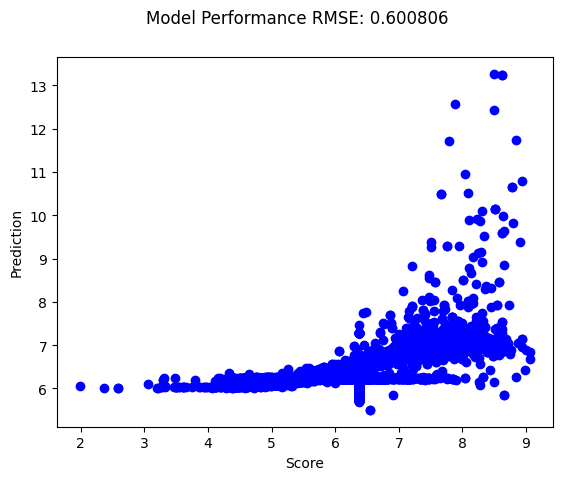

In [97]:
evaluator = RegressionEvaluator(labelCol="Score", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

lrPred = lr_model.transform(final_data)
lrResult = lrPred.sample(withReplacement=False, fraction=0.001, seed=None).toPandas()

plt.plot(lrResult.Score, lrResult.prediction, 'bo')
plt.xlabel('Score')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

In [94]:
lr_model.save("LR_Model")

[('Score', 8.027317358189091e-05), ('Favorites', 5.2315722353027596e-05), ('Members', 1.796745813693906e-05), ('Popularity', 9.252727507657863e-06), ('Scored By', 4.0977426474365455e-06), ('Rank', 2.397253828358642e-06)]


Text(0.5, 1.0, 'Feature Importances')

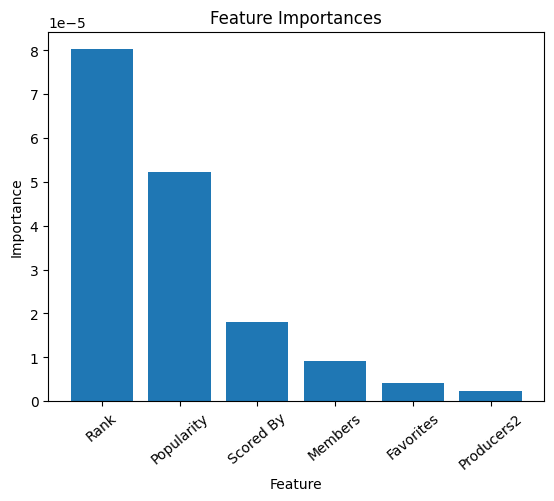

In [98]:
importances = sorted(list(zip(df.columns[:-1], map(abs, lr_model.coefficients))), key=lambda x: x[1], reverse=True)
print(importances)
values = [tup[1] for tup in importances]

x_values = list(range(len(importances)))
plt.bar(x_values, values, orientation = 'vertical')
plt.xticks(x_values, input_cols, rotation=40)

plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [99]:
# 0 - TN
# 1 - FP
# 2 - FN
# 3 - TP
predictions = predictions.withColumn("result", F.when((predictions["Score"] >= 7) & (predictions["prediction"] >= 7), 3) \
                                                .when((predictions["Score"] >= 7) & (predictions["prediction"] < 7), 2) \
                                                .when((predictions["Score"] < 7) & (predictions["prediction"] >= 7), 1) \
                                                .otherwise(0))

In [100]:
tn = predictions.filter(predictions["result"] == 0).count()
fp = predictions.filter(predictions["result"] == 1).count()
fn = predictions.filter(predictions["result"] == 2).count()
tp = predictions.filter(predictions["result"] == 3).count()

In [101]:
print(f"True negatives: {tn}\n \
False negatives: {fn}\n \
False positives: {fp}\n \
True positives: {tp}")

True negatives: 2446430
 False negatives: 366116
 False positives: 27658
 True positives: 147125


In [102]:
accuracy = (tn + tp) / (tn + fn + fp + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

In [103]:
print(f"Accuracy: {accuracy}%\n \
Precision: {precision}%\n \
Recall: {recall}%\n \
F1-Score: {f1_score}%")

Accuracy: 0.8681852584700246%
 Precision: 0.8417580657157733%
 Recall: 0.2866587041954949%
 F1-Score: 0.42767403462669906%


# Random Forest

In [19]:
rf = RandomForestRegressor(labelCol='Score')

In [ ]:
from time import time

startTime = time()

rf_model = rf.fit(train_data)

endTime = time()
print(f"{endTime - startTime} seconds")

In [ ]:
rf_model = RandomForestRegressionModel.load("RF_Model")

In [107]:
predictions_rf = rf_model.transform(test_data)

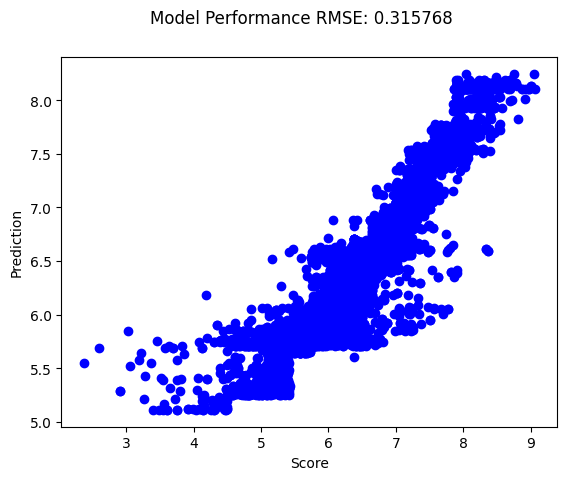

In [108]:
evaluator = RegressionEvaluator(labelCol="Score", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions_rf)

rfPred = rf_model.transform(final_data)
rfResult = rfPred.sample(withReplacement=False, fraction=0.001, seed=None).toPandas()

plt.plot(rfResult.Score, rfResult.prediction, 'bo')
plt.xlabel('Score')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Text(0.5, 1.0, 'Feature Importances')

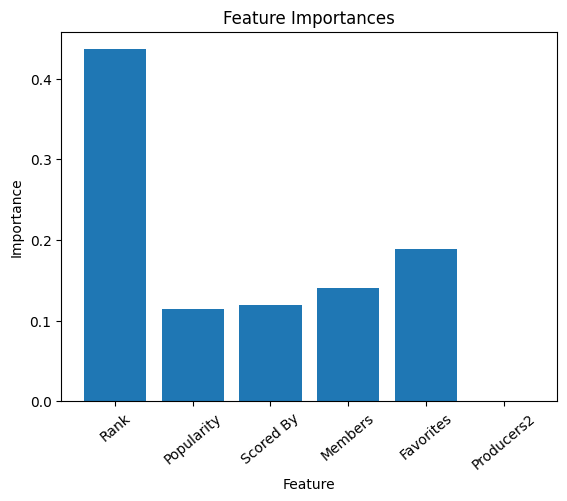

In [109]:
importances = rf_model.featureImportances

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, input_cols, rotation=40)

plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [110]:
predictions_rf.show()

+-----------------+----------------+------------------+
|         features|           Score|        prediction|
+-----------------+----------------+------------------+
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051795615|
|(6,[2],[29967.0])|6.38084071642576|6.3840977051

In [111]:
# 0 - TN
# 1 - FP
# 2 - FN
# 3 - TP
predictions_rf = predictions_rf.withColumn("result", F.when((predictions_rf["Score"] >= 7) & (predictions_rf["prediction"] >= 7), 3) \
                                                .when((predictions_rf["Score"] >= 7) & (predictions_rf["prediction"] < 7), 2) \
                                                .when((predictions_rf["Score"] < 7) & (predictions_rf["prediction"] >= 7), 1) \
                                                .otherwise(0))

In [112]:
tn = predictions_rf.filter(predictions_rf["result"] == 0).count()
fp = predictions_rf.filter(predictions_rf["result"] == 1).count()
fn = predictions_rf.filter(predictions_rf["result"] == 2).count()
tp = predictions_rf.filter(predictions_rf["result"] == 3).count()

In [113]:
print(f"True negatives: {tn}\n \
False negatives: {fn}\n \
False positives: {fp}\n \
True positives: {tp}")

True negatives: 2469515
 False negatives: 79940
 False positives: 4573
 True positives: 433301


In [115]:
accuracy = (tn + tp) / (tn + fn + fp + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

In [116]:
print(f"Accuracy: {accuracy}%\n \
Precision: {precision}%\n \
Recall: {recall}%\n \
F1-Score: {f1_score}%")

Accuracy: 0.9717095104021016%
 Precision: 0.9895563563947619%
 Recall: 0.8442447115487656%
 F1-Score: 0.911143237147979%


In [106]:
rf_model.save("RF_Model")

# Gradient Boosting

In [17]:
gbt = GBTRegressor(labelCol='Score')

In [18]:
from time import time

startTime = time()

gbt_model = gbt.fit(train_data)

endTime = time()
print(f"{endTime - startTime} seconds")

5614.59761428833 seconds


In [ ]:
gbt_model = GBTRegressionModel.load("GBT_Model")

In [120]:
predictions_gbt = gbt_model.transform(test_data)

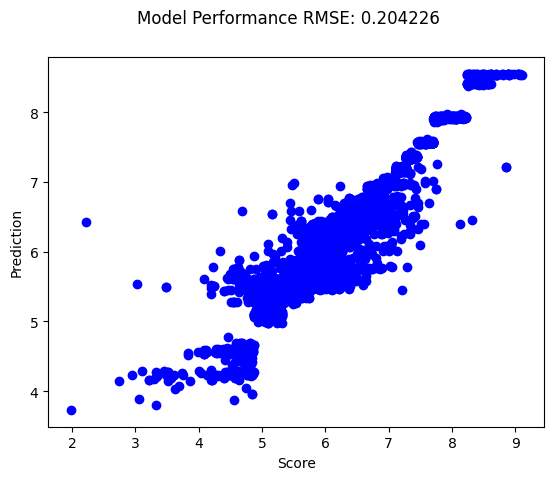

In [121]:
evaluator = RegressionEvaluator(labelCol="Score", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions_gbt)

gbtPred = gbt_model.transform(final_data)
gbtResult = gbtPred.sample(withReplacement=False, fraction=0.001, seed=None).toPandas()

plt.plot(gbtResult.Score, gbtResult.prediction, 'bo')
plt.xlabel('Score')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Text(0.5, 1.0, 'Feature Importances')

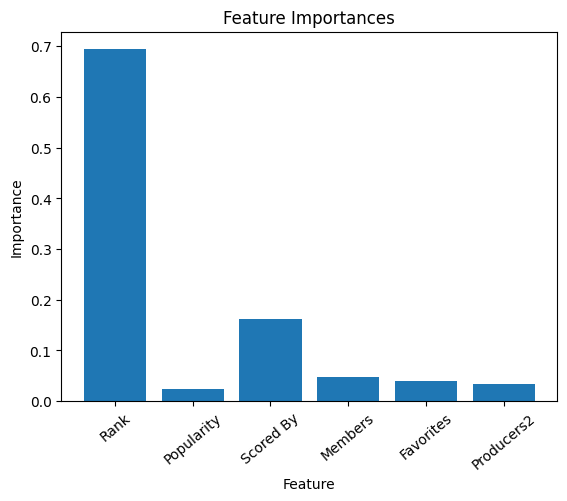

In [122]:
importances = gbt_model.featureImportances

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, input_cols, rotation=40)

plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [123]:
predictions_gbt.show()

+-----------------+----------------+-----------------+
|         features|           Score|       prediction|
+-----------------+----------------+-----------------+
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[29967.0])|6.38084071642576|6.386608388134222|
|(6,[2],[2

In [124]:
# 0 - TN
# 1 - FP
# 2 - FN
# 3 - TP
predictions_gbt = predictions_gbt.withColumn("result", F.when((predictions_gbt["Score"] >= 7) & (predictions_gbt["prediction"] >= 7), 3) \
                                                .when((predictions_gbt["Score"] >= 7) & (predictions_gbt["prediction"] < 7), 2) \
                                                .when((predictions_gbt["Score"] < 7) & (predictions_gbt["prediction"] >= 7), 1) \
                                                .otherwise(0))

In [125]:
tn = predictions_gbt.filter(predictions_gbt["result"] == 0).count()
fp = predictions_gbt.filter(predictions_gbt["result"] == 1).count()
fn = predictions_gbt.filter(predictions_gbt["result"] == 2).count()
tp = predictions_gbt.filter(predictions_gbt["result"] == 3).count()

In [126]:
print(f"True negatives: {tn}\n \
False negatives: {fn}\n \
False positives: {fp}\n \
True positives: {tp}")

True negatives: 2443696
 False negatives: 39836
 False positives: 30392
 True positives: 473405


In [127]:
accuracy = (tn + tp) / (tn + fn + fp + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

In [128]:
print(f"Accuracy: {accuracy}%\n \
Precision: {precision}%\n \
Recall: {recall}%\n \
F1-Score: {f1_score}%")

Accuracy: 0.9764913740669341%
 Precision: 0.9396741147724182%
 Recall: 0.9223834416969806%
 F1-Score: 0.9309484994660967%


In [119]:
gbt_model.save("GBT_Model")